In [1]:
import jax.numpy as jnp
from jax import grad
import matplotlib.pyplot as plt
import numpy as np
from KernelTools import *

In [2]:
n = 30
rho0_samples = jnp.array(np.random.randn(2*n))
rho1_samples = jnp.array(np.hstack([np.random.randn(n//2)/2 - 1.5,np.random.randn(n//2)/2 + 1.5]))

$$G(v) = \mathbb{E}[|v_t(I(x_0,x_1,t))|^2 - 2 \partial_t I(x_0,x_1,t) \cdot v_t(I(x_0,x_1))]$$


In [3]:
def I(x,y,t):
    return jnp.cos(jnp.pi/2 * t)*x + jnp.sin(jnp.pi/2 * t)*y

def It(x,y,t):
    return (-jnp.pi/2)*jnp.sin(jnp.pi/2 * t)*x + (jnp.pi/2) * jnp.cos(jnp.pi/2 * t)*y


def Istacked(x,y,t):
    return jnp.array([jnp.cos(jnp.pi/2 * t)*x + jnp.sin(jnp.pi/2 * t)*y,t])

t_vals = jnp.linspace(0,1,10)


In [4]:
A,B = jnp.meshgrid(rho0_samples,rho1_samples)
X0 = A.flatten()
X1 = B.flatten()


Ix_t = jnp.hstack([[I(X0,X1,t),t*jnp.ones(len(X0))] for t in t_vals]).T
It_vals = jnp.hstack([It(X0,X1,t) for t in t_vals])

In [5]:
k_single = get_gaussianRBF(0.8)
k = vectorize_kfunc(k_single)
K = k(Ix_t,Ix_t)

In [6]:
alpha = jnp.linalg.solve(K+1e-1*diagpart(K),It_vals)

In [7]:
def get_v(x,t):
    return k(jnp.hstack(x,t),Ix_t)

In [8]:
x_grid = jnp.linspace(-4,4,100)
t_grid = jnp.linspace(0,1,50)

In [9]:
pred_grid = [
    k(jnp.vstack([x_grid,t*np.ones(len(x_grid))]).T,Ix_t)@alpha for t in t_grid
]

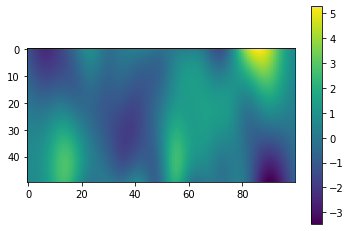

In [10]:
plt.imshow(pred_grid)
plt.colorbar()

In [19]:
from jax.scipy.stats import norm

In [27]:
init_cons = norm.ppf(jnp.linspace(0,1,500)[3:-3])
x_vals = [init_cons]
dt = 0.005
t = 0
x_state = init_cons
t_vals = [t]
for i in range(200):
    t += dt
    t_vals+=[t]
    x_state += dt * k(jnp.vstack([x_state,t*np.ones(len(x_state))]).T,Ix_t)@alpha
    x_vals +=[x_state]

x_vals = jnp.array(x_vals)
t_vals = jnp.array(t_vals)

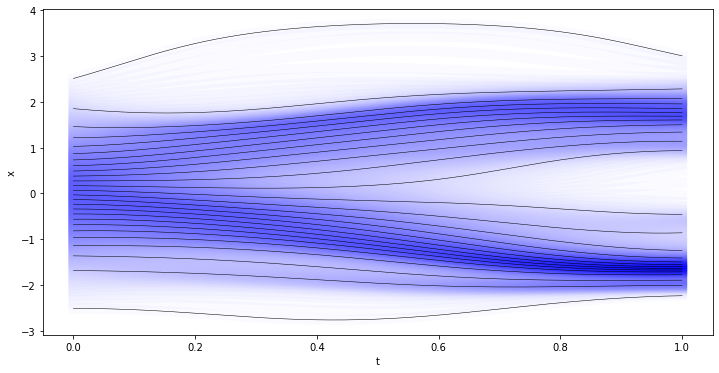

In [39]:
plt.figure(figsize=(12,6))
for col in x_vals.T:
    plt.plot(t_vals,col,c='blue',alpha = 0.02,lw = 10)


for col in x_vals.T[::20]:
    plt.plot(t_vals,col,c='black',lw = 0.5)

plt.plot(t_vals,x_vals.T[-1],c='black',lw = 0.5)
plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [14]:
@jax.jit
def timestep(x_state,t):
    return k(jnp.vstack([x_state,t*np.ones(len(x_state))]).T,Ix_t)@alpha

In [15]:
init_cons = jnp.array(np.random.randn(1500))
x_vals = [init_cons]

dt = 0.005
t = 0
x_state = init_cons
t_vals = [t]
for i in tqdm(range(200)):
    t += dt
    t_vals+=[t]
    x_state += dt * timestep(x_state,t)
    x_vals +=[x_state]

x_vals = jnp.array(x_vals)
t_vals = jnp.array(t_vals)


  0%|          | 0/200 [00:00<?, ?it/s]

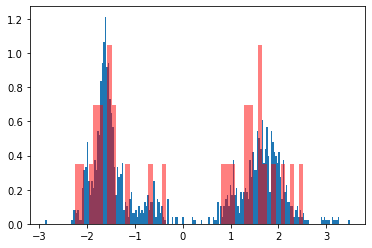

In [16]:
plt.hist(np.array(x_state),200,density=True)
plt.hist(rho1_samples,50,color= 'red',alpha = 0.5,density=True)
plt.show()

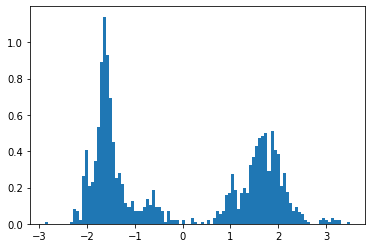

In [18]:
plt.hist(np.array(x_state),100,density=True)
plt.show()